## Motivation
Currently AI is advancing in the field of healthcare to improve detection of malignant tumors, give treatment recommendations, engage patients and support in administrative activities (Davenport and Kalakota 2019). Our goal is to contribute to this field by applying a neural network with transfer learning on a dataset with the aim to detect malignant cells of breast cancer. 

According to Krebsliga Schweiz (2021), there are 6’250 new cases and 1’410 deaths associated with breast cancer in Switzerland every year. Early diagnosis and treatment are a key to increasing the 5-year survival rate of patients.  

From a technical standpoint we want to investigate the performance differences between neural networks with and without transfer learning in the field of tumor detection.

## Data

We use the Kaggle dataset: Breast Histopathology Images, which contains 277’524 images that are classified whether the sample is positive or negative for Invasive Ductal Carcinoma (IDC). Therefore, we face a binary classification problem with this dataset. The sample dataset contains images scanned at 40x zoom that are prepared in 50 x 50-pixel patches.

[Kaggle Dataset](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)

### Import Packages

In [28]:
import IPython
import pandas as pd
import numpy as np
import datetime
import pickle

# used to access folder structures
import os

# used to open images
import PIL

# Graphs, visualizations
import matplotlib.pyplot
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import scipy

# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
# For Image Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
# from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD


from sklearn.model_selection import train_test_split

In [3]:
# Check for gpu support
# Troubleshooting: 
# Python Version = 3.7.9
# tensorflow Version = 2.3.0
# tf.keras Version = 2.4.0

# from platform import python_version
# print(python_version())
# print(tf.__version__)
# print(tf.keras.__version__)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load the Data

In [14]:
# Import Data From Pickle file

with open('y.pickle', 'rb') as f:
    y_data = pickle.load(f)
f.close()
y_data

with open('X.pickle', 'rb') as f:
    X_data = pickle.load(f)
f.close()
type(X_data)

list

### Learnings
* The data of positive and negative samples is unbalanced, where patients have more negative patches than positive ones
* This could lead to an imbalanced result where we classify more patches as negative, which would be a severe mistake in cancer detection. A confusion matrix should be sufficient so verify this concern, when the model is trained

In [21]:
#Train-validation-test split

x_train,x_test,y_train,y_test=train_test_split(np.asarray(X_data)[:1000],np.asarray(y_data)[:1000],test_size=.3, random_state=42)
del X_data
del y_data
#x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

#Dimension of the kaggle dataset
print((x_train.shape,y_train.shape))
#print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

input_shape=x_train.shape[1:]
input_shape

((700, 50, 50, 3), (700,))
((300, 50, 50, 3), (300,))


(50, 50, 3)

In [20]:
np.asarray(X_data)[:1000].shape

(1000, 50, 50, 3)

### Functions for plotting

In [45]:
def acc_plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    return plt

def loss_plot(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper left')
    return plt

### General model settings

In [22]:
#Learning Rate Annealer
lrr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.1,
                       patience=5,
                       min_lr=1e-8,
                       verbose=2)


#Early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=2,
                                      mode='auto', baseline=None, restore_best_weights=True)

In [31]:
# training settings
batch_size = 100
epochs = 50

# Transfer learning

For our transfer learning setting, we use Resnet50. Resnet50 is a deep convolutional network with, as the name states, 50 layers. Out of these 50 layers, 48 are convolutional layers, besides that it contains an average pooling layer and a maxpooling layer.\
It was trained with more than a million images from ImageNet (http://www.image-net.org/). Originally, the network was trained for multiclass classification with 1000 categories.\
The Keras API allows to load the Resnet50 with weights trained on image net. This is done with the keyword weights='imagenet'. Furthermore, Keras enables the user to define his own input shape. This is only possible if the original dense layer at the top of the network is not loaded. Therefore we use include_top=False. However, the number of channels must be 3 as the network was trained on colored images. Of course, we also freez the pretained weights, meaning that we don't update them during training.\
Firstly, we implement a simple network using resnet50. We call it simple, as we use just two denslayers to connect the Resnet50 with the desired output for our task. Before the Resnet50, we don't use any layer at all, but connect our input, images of the shape 50x50x3, directly to the Resnet50.\
In a next step, we try to enhance the model by adding layers before the Resnet50 and in a third step by adding a more complex architecture after Resnet50.

In this part of the project, we'd like to focus on the effect of the layers before and after the pretrained model, thus we don't conduct any experiments with different hyperparameters.

## Simple Transfer learning

In [41]:
input_shape = (50, 50, 3)
model_input = keras.Input(shape=input_shape)
#beforeModel = keras.layers.UpSampling2D()(model_input)
#beforeModel = keras.layers.UpSampling2D()(beforeModel)
# load pretrained resnet, don't train resnet
#print(beforeModel)
resnet = keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(50,50,3))
resnet.trainable=False
x = resnet(model_input,training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024,
                       kernel_regularizer=l2(0.001),
                       bias_regularizer=l2(0.001),
                       activation='relu')(x) # dense layer 1 
output = keras.layers.Dense(units=1, activation='sigmoid')(x)

In [42]:
model = keras.Model(inputs = model_input, outputs = output)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 50, 50, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 1025      
Total params: 31,978,369
Trainable params: 8,390,657
Non-trainable params: 23,587,712
_________________________________________________________________


In [35]:
model.compile(loss="binary_crossentropy", optimizer=Adam(epsilon=0.1, learning_rate=0.001), metrics=["accuracy"])
log_dir= os.path.join('logs','ResNet50',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),'')

# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history=model.fit(x_train, y_train,
                  batch_size=batch_size, epochs=epochs,
                  validation_split=.3,
                  callbacks=[es, lrr],
                 ) 

Epoch 1/50
5/5 [==============================] - 170s 39s/step - loss: 2.3457 - accuracy: 0.9297 - val_loss: 2.2560 - val_accuracy: 0.9194
Epoch 2/50
5/5 [==============================] - 203s 44s/step - loss: 2.1999 - accuracy: 0.9464 - val_loss: 2.1988 - val_accuracy: 0.9573
Epoch 3/50
5/5 [==============================] - 202s 42s/step - loss: 2.1496 - accuracy: 0.9566 - val_loss: 2.1849 - val_accuracy: 0.9526
Epoch 4/50
5/5 [==============================] - 201s 43s/step - loss: 2.0900 - accuracy: 0.9787 - val_loss: 2.1837 - val_accuracy: 0.9621
Epoch 5/50
5/5 [==============================] - 202s 43s/step - loss: 2.0781 - accuracy: 0.9830 - val_loss: 2.1802 - val_accuracy: 0.9573
Epoch 6/50
5/5 [==============================] - 199s 42s/step - loss: 2.0618 - accuracy: 0.9957 - val_loss: 2.1764 - val_accuracy: 0.9573
Epoch 7/50
5/5 [==============================] - 201s 43s/step - loss: 2.0523 - accuracy: 0.9978 - val_loss: 2.1796 - val_accuracy: 0.9621
Epoch 8/50
5/5 [====

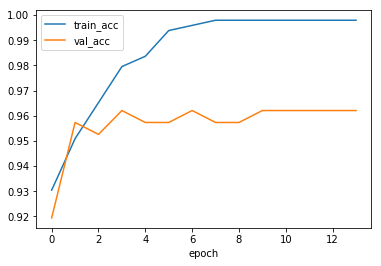

In [44]:
# plot accuracy
plt = acc_plot(history)
plt.show()

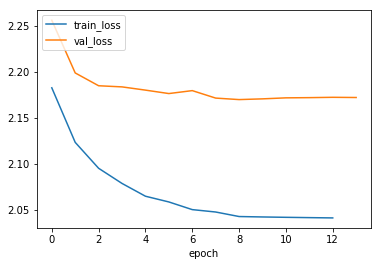

In [46]:
# plot loss
plt = loss_plot(history)
plt.show()

In [39]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print(F"test loss {results[0]:.2f},\ntest acc: {results[1]:1.2f}")

Evaluate on test data
3/3 [==============================] - 25s 7s/step - loss: 2.2858 - accuracy: 0.9100
test loss 2.29,
test acc: 0.91


### Advanced Transfer Learning I

As mentioned, we try to improve the performance by changing the architecture before the Resnet50. For the simple model, we connected our input directly to the Resnet50. Now, we use UpSamling2D layers, these layers just double the input size but are not able to learn anything. Thus, for the advanced model, each UpSamling2D layer is followed by a Conv2D layer that maintains the shape. The intuition is that the Conv2D layer can learn something from the upsampled input before upsampling it further.

In [47]:
model_input = keras.Input(shape=input_shape)
beforeModel = keras.layers.UpSampling2D()(model_input)
beforeModel = keras.layers.Conv2D(3, 3, strides=1, padding="same")(beforeModel)
beforeModel = keras.layers.UpSampling2D()(beforeModel)
beforeModel = keras.layers.Conv2D(3, 3, strides=1, padding="same")(beforeModel)

resnet = keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(200,200,3))
resnet.trainable=False
x = resnet(beforeModel,training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024,
                       kernel_regularizer=l2(0.001),
                       bias_regularizer=l2(0.001),
                       activation='relu')(x) # dense layer 1 
output = keras.layers.Dense(units=1, activation='sigmoid')(x)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), name='conv2d_4/BiasAdd:0', description="created by layer 'conv2d_4'")


In [13]:
model = keras.Model(inputs = model_input, outputs = output)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 50, 50, 3)]       0         
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 3)       84        
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 3)       84        
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0   

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=Adam(epsilon=0.1, learning_rate=0.001), metrics=["accuracy"])
log_dir= os.path.join('logs','ResNet50',datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),'')

# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history=model.fit(train_generator.flow(x_train, y_train),
                  batch_size=batch_size, epochs=epochs,
                  validation_data=val_generator.flow(x_val, y_val),
                  callbacks=[es, lrr]) 

In [ ]:
# plot accuracy
plt = acc_plot(history)
plt.show()

In [ ]:
# plot loss
plt = loss_plot(history)
plt.show()

### Advanced Transfer Learning II

Finally, we attempt to improve the performance further by altering the architecture after the Resnet50. We introduce two types of regularization layers, namely BatchNormalization and Dropout.

In [ ]:
model_input = keras.Input(shape=input_shape)
beforeModel = keras.layers.UpSampling2D()(model_input)
beforeModel = keras.layers.Conv2D(3, 3, strides=1, padding="same")(beforeModel)
beforeModel = keras.layers.UpSampling2D()(beforeModel)
beforeModel = keras.layers.Conv2D(3, 3, strides=1, padding="same")(beforeModel)
print(beforeModel)
resnet = keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=(200,200,3))
resnet.trainable=False
x = resnet(beforeModel,training=False)

x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024,
                       kernel_regularizer=l2(0.001),
                       bias_regularizer=l2(0.001),
                       activation='relu')(x) # dense layer 1 

x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512,
                       activation='relu',
                       kernel_regularizer=l2(0.001),
                       bias_regularizer=l2(0.001))(x) # dense layer 2
x = keras.layers.Dropout(0.2)(x) 

output = keras.layers.Dense(units=1, activation='sigmoid')(x)